In [1]:
from argparse import Namespace
args = Namespace(
  num_classes=2139,
  in_channels=1,
  model_name='caformer_m36.sail_in22k_ft_in1k_384',
  
  
  device='cuda',
  lr=1e-5,
  freeze_body=False,
  warmup_steps=8,
  batchsize=400,
  grad_accumulation_steps=4,
  num_steps=1000, 
  num_epochs=50, 
  checkpointing_steps=2000,
  save_path='./working/my_classifier/caformer_m36.sail_in22k_ft_in1k_384'
)

In [2]:
from classification.dataset import ClassifyDataset
from classification.transform import *
from torch.utils.data import DataLoader


batchsize = args.batchsize
if args.freeze_body: batchsize *= 4
train = ClassifyDataset('input/classification/train.csv', transform=train_transform)
val = ClassifyDataset('input/classification/test.csv', transform=test_transform)
# train.df = train.df.iloc[:5000]
train_loader = DataLoader(train, batchsize, True, num_workers=10)
val_loader = DataLoader(val, batchsize)

In [3]:
from timm import create_model
from fastai.vision.learner import _update_first_layer, has_pool_type, create_head, num_features_model
import torch.nn as nn


def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NameError("cut must be either integer or function")

body = create_timm_body(args.model_name, pretrained=True, n_in=args.in_channels)
nf = num_features_model(body)
# head = create_head(nf, args.num_classes)
# model = nn.Sequential(body, head)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/caformer_m36.sail_in22k_ft_in1k_384)
INFO:timm.models._hub:[timm/caformer_m36.sail_in22k_ft_in1k_384] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [4]:
from classification.ml_decoder.ml_decoder.ml_decoder import MLDecoder
from utils import get_model_size

ml_decoder_head = MLDecoder(args.num_classes, initial_num_features=nf, decoder_embedding=768)
model = nn.Sequential(body, ml_decoder_head)
get_model_size(model), get_model_size(body)

('78.71M', '52.555M')

In [5]:
def freeze_body():
  ct = 0
  for child in model[0].children():
    ct += 1
    if ct < 8:
      for param in child.parameters():
        param.requires_grad = False
if args.freeze_body:
  freeze_body()

In [6]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total  = sum(p.numel() for p in model.parameters())
  trainable  = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total, trainable

total, trainable = pytorch_count_params(model)
print(f"Total: {total/1e6:.4f}M, Trainable: {trainable/1e6:.4f}M")

Total: 78.8304M, Trainable: 78.7104M


In [7]:
import torch
body(torch.randn(7, 1, 64, 64)).shape

torch.Size([7, 576, 2, 2])

In [8]:
nf

576

In [9]:
import torch
import os

def save_model(step, best_score):
  # save_dir = os.path.join(args.save_path, 'ckpt%d'%step)
  os.makedirs(args.save_path, exist_ok=True)
  # torch.save((best_score, model.state_dict()), os.path.join(save_dir, 'pytorch_model.bin'))
  torch.save((best_score, model.state_dict()), os.path.join(args.save_path, 'pytorch_model.bin'))

def load_model(prev_score):
  if os.path.isfile(os.path.join(args.save_path, 'pytorch_model.bin')):
    best_score, state_dict = torch.load(os.path.join(args.save_path, 'pytorch_model.bin'))
    if best_score > prev_score:
      model.load_state_dict(state_dict)
      print('loaded')
      prev_score = best_score
  return prev_score

In [10]:
from timm.loss.cross_entropy import LabelSmoothingCrossEntropy
import torch.nn as nn
import torch.nn.functional as F
import torch

loss_function = F.cross_entropy
# loss_function = LabelSmoothingCrossEntropy(smoothing=1e-6)
model.to('cpu')
out = model(torch.randn(7, 1, 64, 64))
labels = torch.randint(0, args.num_classes, (7,))
loss_function(out, labels)

tensor(8.8689, grad_fn=<NllLossBackward0>)

In [11]:
from sklearn.metrics import top_k_accuracy_score
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def eval():
  pbar = tqdm(val_loader)
  model.to('cuda')
  model.eval()
  y_pred = []
  y_true = []
  with torch.no_grad():
    for sample in pbar:
      image, label = sample
      image = image.cuda()
      out = model(image)
      out = F.softmax(out, dim=1)
      
      y_pred += [out.detach().cpu().numpy()]
      y_true += [label.cpu().numpy()]
  
  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.concatenate(y_pred, axis=0)
  return (top_k_accuracy_score(y_true, y_pred, k=1, labels=range(args.num_classes)),
        top_k_accuracy_score(y_true, y_pred, k=5, labels=range(args.num_classes)))
    
    

In [12]:
from torch.optim import AdamW, SGD
from lion_pytorch import Lion
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

opt = Lion(model.parameters(), lr=args.lr, weight_decay=1e-2)
# opt = AdamW(model.parameters(), lr=args.lr/10)
# opt = SGD(model.parameters(), lr=args.lr)
warmup = LinearLR(opt, start_factor=1/args.warmup_steps, total_iters=args.warmup_steps)
reduce = CosineAnnealingLR(opt, T_max=args.num_epochs * len(train_loader))
scheduler = SequentialLR(opt, [warmup, reduce], milestones=[args.warmup_steps])

In [13]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

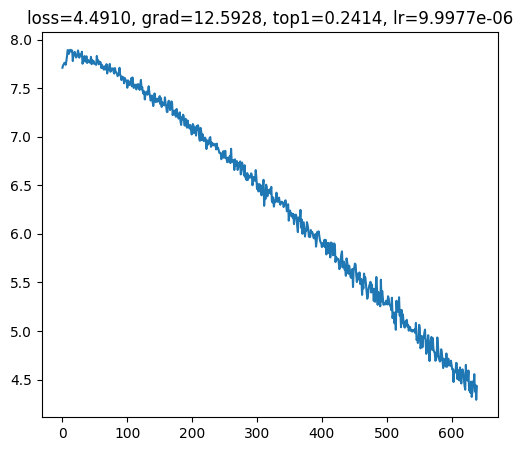

loss=4.4139, grad=12.4174, top1=0.2527, lr=9.9976e-06: 100%|██████████| 650/650 [14:55<00:00,  1.38s/it]
 93%|█████████▎| 68/73 [00:55<00:03,  1.26it/s]

In [14]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score

plot = True
plot_every = 20

losses = []
accs = []
grads = []
model.to(args.device)
step = 0
best_score = 0.0

best_score = load_model(best_score)
for epoch in range(1, args.num_epochs + 1):
  pbar = tqdm(train_loader)
  for sample in pbar:
    step += 1
    model.train()
    
    image, label = sample
    image = torch.autograd.Variable(image.cuda())
    label = torch.autograd.Variable(label.cuda())
    opt.zero_grad()
    out = model(image)
    loss = loss_function(out, label)
    loss.backward()
    
    grad = torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
    opt.step()
    scheduler.step()
    losses += [loss.cpu().detach().item()]
    grads += [grad.cpu().detach().item()]
    # acc = accuracy_score(label.detach().cpu().numpy(),
    #                      out.detach().cpu().argmax(dim=1).numpy())
    # accs += [acc]
    accs += [top_k_accuracy_score(
      label.detach().cpu().numpy(), out.detach().cpu().numpy(),
      k=1, labels=range(args.num_classes))]
    
    
    if plot and step % plot_every == 0: 
      clear_output(True)
      plt.figure(figsize=(20, 5))
      plt.subplot(131)
      plt.title('loss=%.4f, grad=%.4f, top1=%.4f, lr=%.4e' % (
      np.mean(losses[-32:]), np.mean(grads[-16:]), np.mean(accs[-32:]), scheduler.get_last_lr()[-1]))
      plt.plot(losses)
      plt.show()
      
    pbar.set_description_str('loss=%.4f, grad=%.4f, top1=%.4f, lr=%.4e' % (
      np.mean(losses[-32:]), np.mean(grads[-16:]), np.mean(accs[-32:]), scheduler.get_last_lr()[-1]))
    if step % args.checkpointing_steps == 0:
      top1, top5 = eval()
      print("Top1: %.4f, Top5: %.4f" % (top1, top5))
      if top5 > best_score:
        save_model(step, top5)
        best_score = top5
        print('New best: %.4f' % top5)
      # save_model(os.path.join(args.save_path, 'checkpoint_%d' % step))
    del image, label
  
  top1, top5 = eval()
  print("Top1: %.4f, Top5: %.4f" % (top1, top5))
  if top5 > best_score:
    save_model(step, top5)
    best_score = top5
    print('New best: %.4f' % top5)
  

In [ ]:
load_model(0.0)

loaded


0.8125

In [ ]:
top1, top5 = eval()

100%|██████████| 29/29 [00:05<00:00,  5.14it/s]


In [ ]:
top1, top5

(0.6594827586206896, 0.8125)

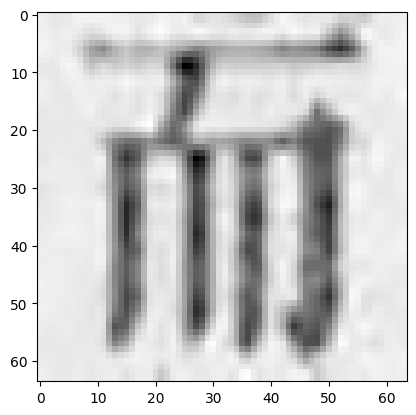

In [ ]:
import matplotlib.pyplot as plt

image, label = next(iter(train_loader))
image = image[0].cpu().numpy().transpose(1, 2, 0)

plt.imshow(image, cmap='gray')